In [1]:
# Can SINDy-driven dynamical system used as reservoir?
# DS to use: 
#1) Explosive Kuramoto Model
#2) Adaptive Macroscopic Kuramoto Model
#3) Single Pendulum
#4) DNA Reservoir
#5) Delay-coupled Reservoir (CadA and CzcCBA sys-tem dynamics)


# 학회 포스터는 1) Explosive Kuramoto Model 3) Single Pendulum 4) DNA Reservoir 정도로 만족
# Things to look at:
# - Do they exhibit similar characteristics with Original Data?
# - Do they exhitbit criticality?

# Generate Synthetic Data From Equations (Real data is much better, ex) 진자->영상찍기, 브레인->MRI데이터)
# USE SINDy to find equations
# Feed inputs and train, predict
# Test sets can be narma, mackey glass, kuramoto synvansky

## 1. Explosive Kuramoto Model

The Kuramoto model describes a system of coupled phase oscillators. The equations for a system of 5 coupled Kuramoto oscillators can be written as follows:

\begin{align*}
\frac{d\theta_1}{dt} &= \omega_1 + \frac{K}{N} \left[ \sin(\theta_2 - \theta_1) + \sin(\theta_3 - \theta_1) + \sin(\theta_4 - \theta_1) + \sin(\theta_5 - \theta_1) \right] \\
\frac{d\theta_2}{dt} &= \omega_2 + \frac{K}{N} \left[ \sin(\theta_1 - \theta_2) + \sin(\theta_3 - \theta_2) + \sin(\theta_4 - \theta_2) + \sin(\theta_5 - \theta_2) \right] \\
\frac{d\theta_3}{dt} &= \omega_3 + \frac{K}{N} \left[ \sin(\theta_1 - \theta_3) + \sin(\theta_2 - \theta_3) + \sin(\theta_4 - \theta_3) + \sin(\theta_5 - \theta_3) \right] \\
\frac{d\theta_4}{dt} &= \omega_4 + \frac{K}{N} \left[ \sin(\theta_1 - \theta_4) + \sin(\theta_2 - \theta_4) + \sin(\theta_3 - \theta_4) + \sin(\theta_5 - \theta_4) \right] \\
\frac{d\theta_5}{dt} &= \omega_5 + \frac{K}{N} \left[ \sin(\theta_1 - \theta_5) + \sin(\theta_2 - \theta_5) + \sin(\theta_3 - \theta_5) + \sin(\theta_4 - \theta_5) \right]
\end{align*}


In [2]:
from data_generation import generate_explosive_kuramoto_data, sim_explosive_kuramoto_data
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from kuramoto import plot_activity, plot_phase_coherence

In [3]:
# Set random seed for reproducibility
np.random.seed(4)

# Define simulation parameters
N = 5
t_span = [0, 20]
t_eval = np.linspace(t_span[0], t_span[1], 2001)
K = 2.4

# Generate data
sol, omega = generate_explosive_kuramoto_data(N, t_span, t_eval, K, seed=4)

In [4]:
np.random.seed(41)
omega = np.loadtxt('natfreqs_default.txt')[67:72]
K = 2.4
phase = np.zeros(5)
adj_mat = np.loadtxt('adj_mat_default.txt')[67:72,67:72]

sol = sim_explosive_kuramoto_data(omega.shape[0], 
                                  t_span=[0,20], 
                                  t_eval=np.linspace(0, 20, 2001), 
                                  K=K, omega=omega, 
                                  y0=np.random.randn(5), 
                                  adj_mat=adj_mat)

In [35]:
t_eval=np.linspace(0, 100, 10001)

In [ ]:
# Include sin(x-y) term in library
library_functions = [lambda x, y: np.sin(x - y)]
library_function_names = [lambda x, y: "sin(" + x + "-" + y + ")"]
custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
poly_library = ps.PolynomialLibrary(degree=1)  # For constants (w_i)
combined_library = custom_library + poly_library  # Concatenate library
fourier_library = ps.FourierLibrary()

optimizer = ps.STLSQ(threshold=0.03)  # Threshold varies by random w (TODO: adaptive threshold?)

# Instantiate and fit the SINDy model
model = ps.SINDy(optimizer=optimizer, feature_library=fourier_library+poly_library)
model.fit(sol.y.T[:], t=t_eval[:], unbias=False)  # unbias=False has better performance

# Simulate the data using the discovered equations
sim = model.simulate(sol.y[:, 0], t=t_eval)
model.print()

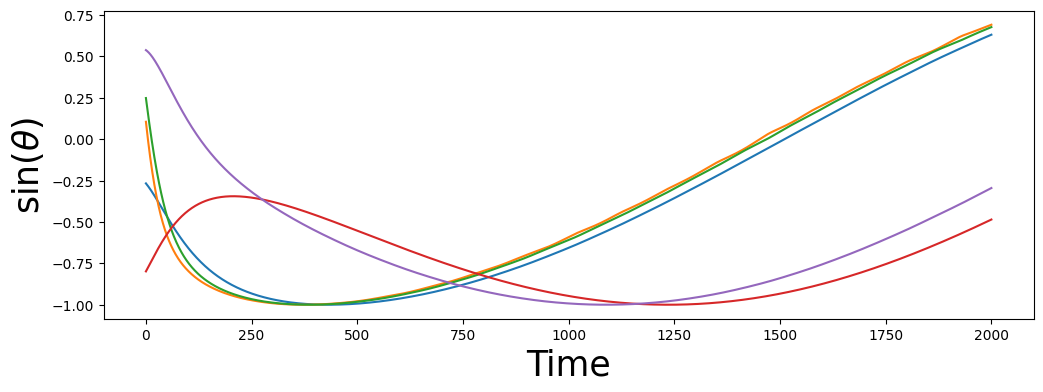

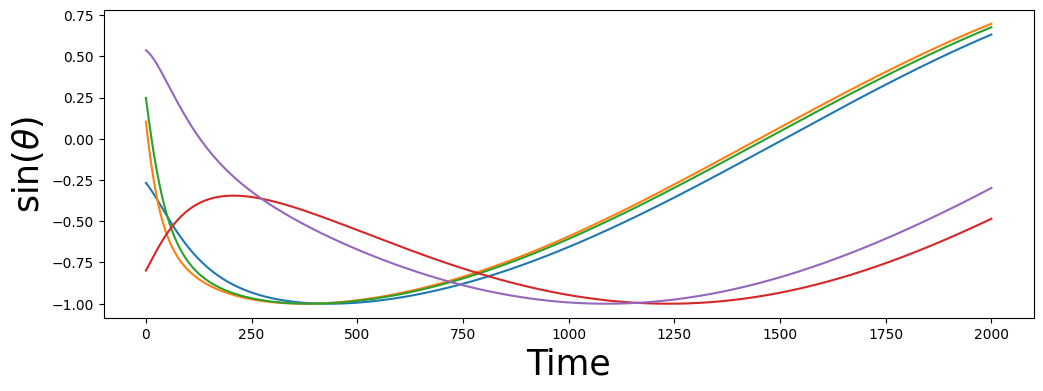

In [6]:
plot_activity(sol.y)
plot_activity(sim.T)

In [17]:
def phase_coherence(angles_vec):
    '''
    Compute global order parameter R_t - mean length of resultant vector
    '''
    suma = sum([(np.e ** (1j * i)) for i in angles_vec])
    return abs(suma / len(angles_vec))

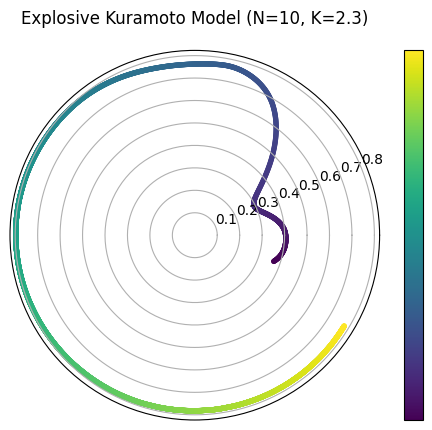

<Figure size 640x480 with 0 Axes>

In [225]:
import networkx as nx
# Heavy calc for plots
np.random.seed(42)
N=10
omega = np.random.randn(N)
K = 2.3
phase = np.pi*np.random.uniform(-2*np.pi, 2*np.pi, N)
graph_nx = nx.erdos_renyi_graph(n=N, p=1) # p=1 -> all-to-all connectivity
adj_mat = nx.to_numpy_array(graph_nx)

sol = sim_explosive_kuramoto_data(omega.shape[0], 
                                  t_span=[0,50], 
                                  t_eval=np.linspace(0, 50, 5001), 
                                  K=K, omega=omega, 
                                  y0=phase, 
                                  adj_mat=adj_mat)

psi = np.mean(sol.y, axis=0)
r = [phase_coherence(vec) for vec in sol.y.T]


fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
plot_ax = ax.scatter(psi, r, c=psi, cmap='viridis', s=8)
#ax.plot(psi[0], r[0], 'ro')   # Dot = Start   * --> o
#ax.plot(psi[-1], r[-1], 'r*') # Star = End    * --> o
ax.grid(True)
ax.get_xaxis().set_ticks([])

cbar = fig.colorbar(plot_ax)
cbar.set_ticks([])
plt.title('Explosive Kuramoto Model (N=10, K=2.3)')
plt.show()
plt.savefig('PolarKuramoto.png')

In [234]:
# Include sin(x-y) term in library
library_functions = [lambda x, y: np.sin(x - y)]
library_function_names = [lambda x, y: "sin(" + x + "-" + y + ")"]
custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
poly_library = ps.PolynomialLibrary(degree=1)  # For constants (w_i)
combined_library = custom_library + poly_library  # Concatenate library
fourier_library = ps.FourierLibrary()

optimizer = ps.STLSQ(threshold=0.0001)  # Threshold varies by random w (TODO: adaptive threshold?)

t_eval=np.linspace(0, 50, 5001)

# Instantiate and fit the SINDy model
model = ps.SINDy(optimizer=optimizer, feature_library=fourier_library+poly_library+custom_library)
model.fit(sol.y.T[:3000], t=t_eval[:3000], unbias=False)  # unbias=False has better performance
model.print()
# Simulate the data using the discovered equations
sim = model.simulate(phase, t=t_eval[:])


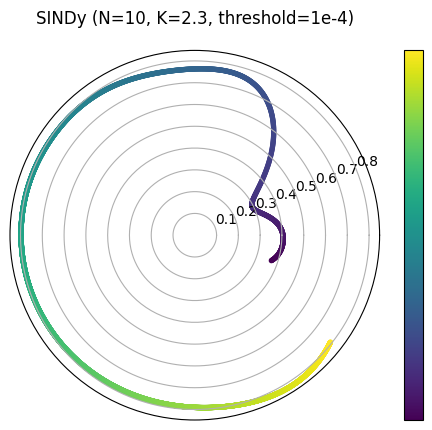

<Figure size 640x480 with 0 Axes>

In [233]:
psi = np.mean(sim.T, axis=0)
r = [phase_coherence(vec) for vec in sim]

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
plot_ax = ax.scatter(psi, r, c=psi, cmap='viridis', s=8)
#ax.plot(psi[0], r[0], 'ro')   # Dot = Start   * --> o
#ax.plot(psi[-1], r[-1], 'r*') # Star = End    * --> o
ax.grid(True)
ax.get_xaxis().set_ticks([])

cbar = fig.colorbar(plot_ax)
cbar.set_ticks([])
plt.title('SINDy (N=10, K=2.3, threshold=1e-4)')
plt.show()
plt.savefig('PolarSINDy_1e-4.png')

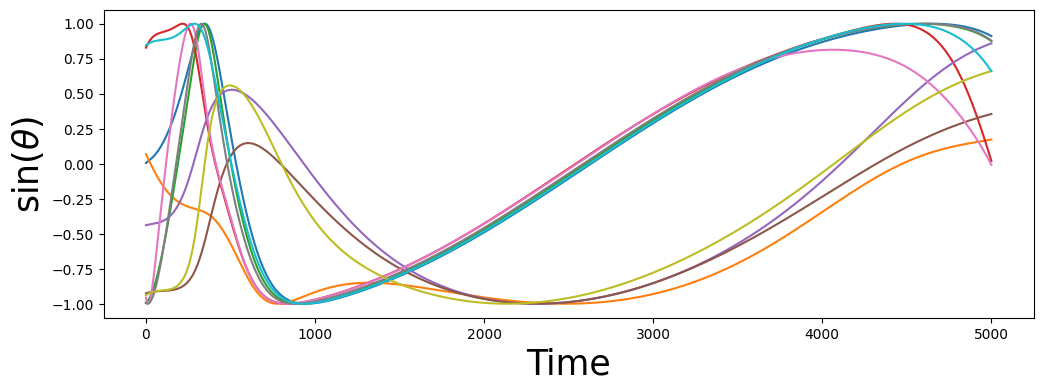

In [212]:
plot_activity(sim.T)

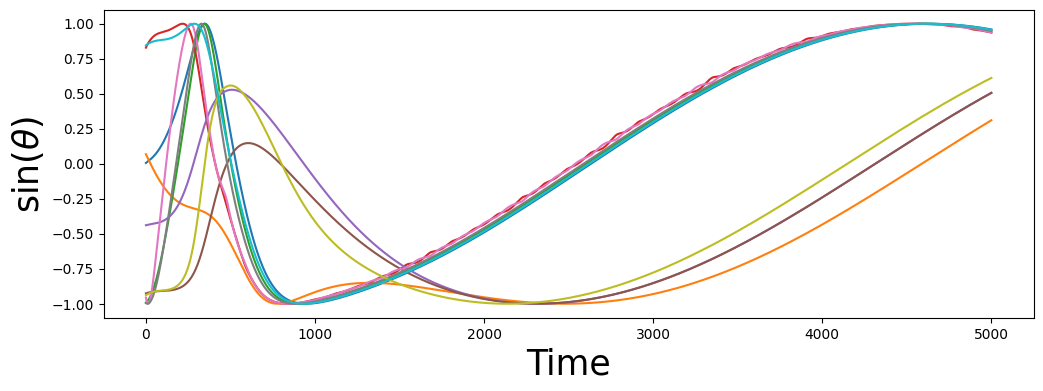

In [213]:
plot_activity(sol.y)

In [7]:
def perturb(state, x, node_index = 1):
    state[node_index] += x[0]
    return state

def get_reservoir(K, omega, phase, x, adj_mat):
    init = perturb(phase, x)
    sim = sim_explosive_kuramoto_data(omega.shape[0], t_span=[0,1], t_eval=np.linspace(0, 1, 101), K=K, omega=omega, y0=init, adj_mat=adj_mat)
    reservoir = np.diff(sim.y[:,::10], n=1, axis=1).reshape(-1, 1)
    last_phase = sim.y[:,-1]

#     sim = model.simulate(init, t=np.linspace(0, 1, 101)).T
#     reservoir = np.diff(sim[:,::10], n=1, axis=1).reshape(-1, 1)
#     last_phase = sim[:,-1]

    return reservoir, last_phase

In [8]:
from NARMA10 import getData

In [9]:
import numpy as np
from reservoirpy import Node
from reservoirpy.nodes import Reservoir, Ridge, Input
import matplotlib.pyplot as plt
import reservoirpy as rpy
rpy.verbosity(0)
phases = []
states = []
xs = []
# Define the custom reservoir node
def forward(node: Node, x: np.ndarray) -> np.ndarray:
    # Retrieve the current state of the node
    state = node.state().reshape(-1, 1)
    states.append(state)
    phase = node.phase
    phases.append(phase)
    xs.append(x[0])
    # Apply the ESN update rule
    updated_state, updated_phase = get_reservoir(node.K, node.omega, phase, x, node.adj_mat)
    node.phase = updated_phase
    # Store the updated state
    return updated_state[:,0]

def initialize(node: Node, x: np.ndarray = None, y: np.ndarray=None):
    if x is not None:
        # Set input and output dimensions
        node.set_input_dim(x.shape[1])
        node.set_output_dim(node.output_dim)
        # Initialize reservoir weights
        

# Instantiate the custom reservoir node
reservoir_node = Node(
    forward=forward,
    initializer=initialize,
    output_dim=50,  # Number of neurons in the reservoir
    #name="P63",
    params={"omega": np.loadtxt('natfreqs_default.txt')[67:72], 
            "K": 2.4, 
            "phase": np.zeros(5), 
            "adj_mat":np.loadtxt('adj_mat_default.txt')[67:72,67:72]},
)

# Set up the ESN architecture
data = Input(input_dim=1)
readout = Ridge(ridge=1e-6)
esn = data >> reservoir_node >> readout

# Generate some example data (sine wave)
X = np.linspace(0, 100, 501).reshape(-1, 1)
y = np.sin(X)*0.5

mackey_glass = np.loadtxt('MackeyGlass_t17.txt').reshape(-1, 1)
X = mackey_glass[:200]
y = mackey_glass[1:201]

X_NARMA, Y_NARMA = getData(2000,0)
X = X_NARMA[:1000].reshape(-1, 1)
y = Y_NARMA[:1000]
# Train the ESN
esn.fit(X, y, warmup=50)

# Generate a forecast
forecast = esn.run(X,)


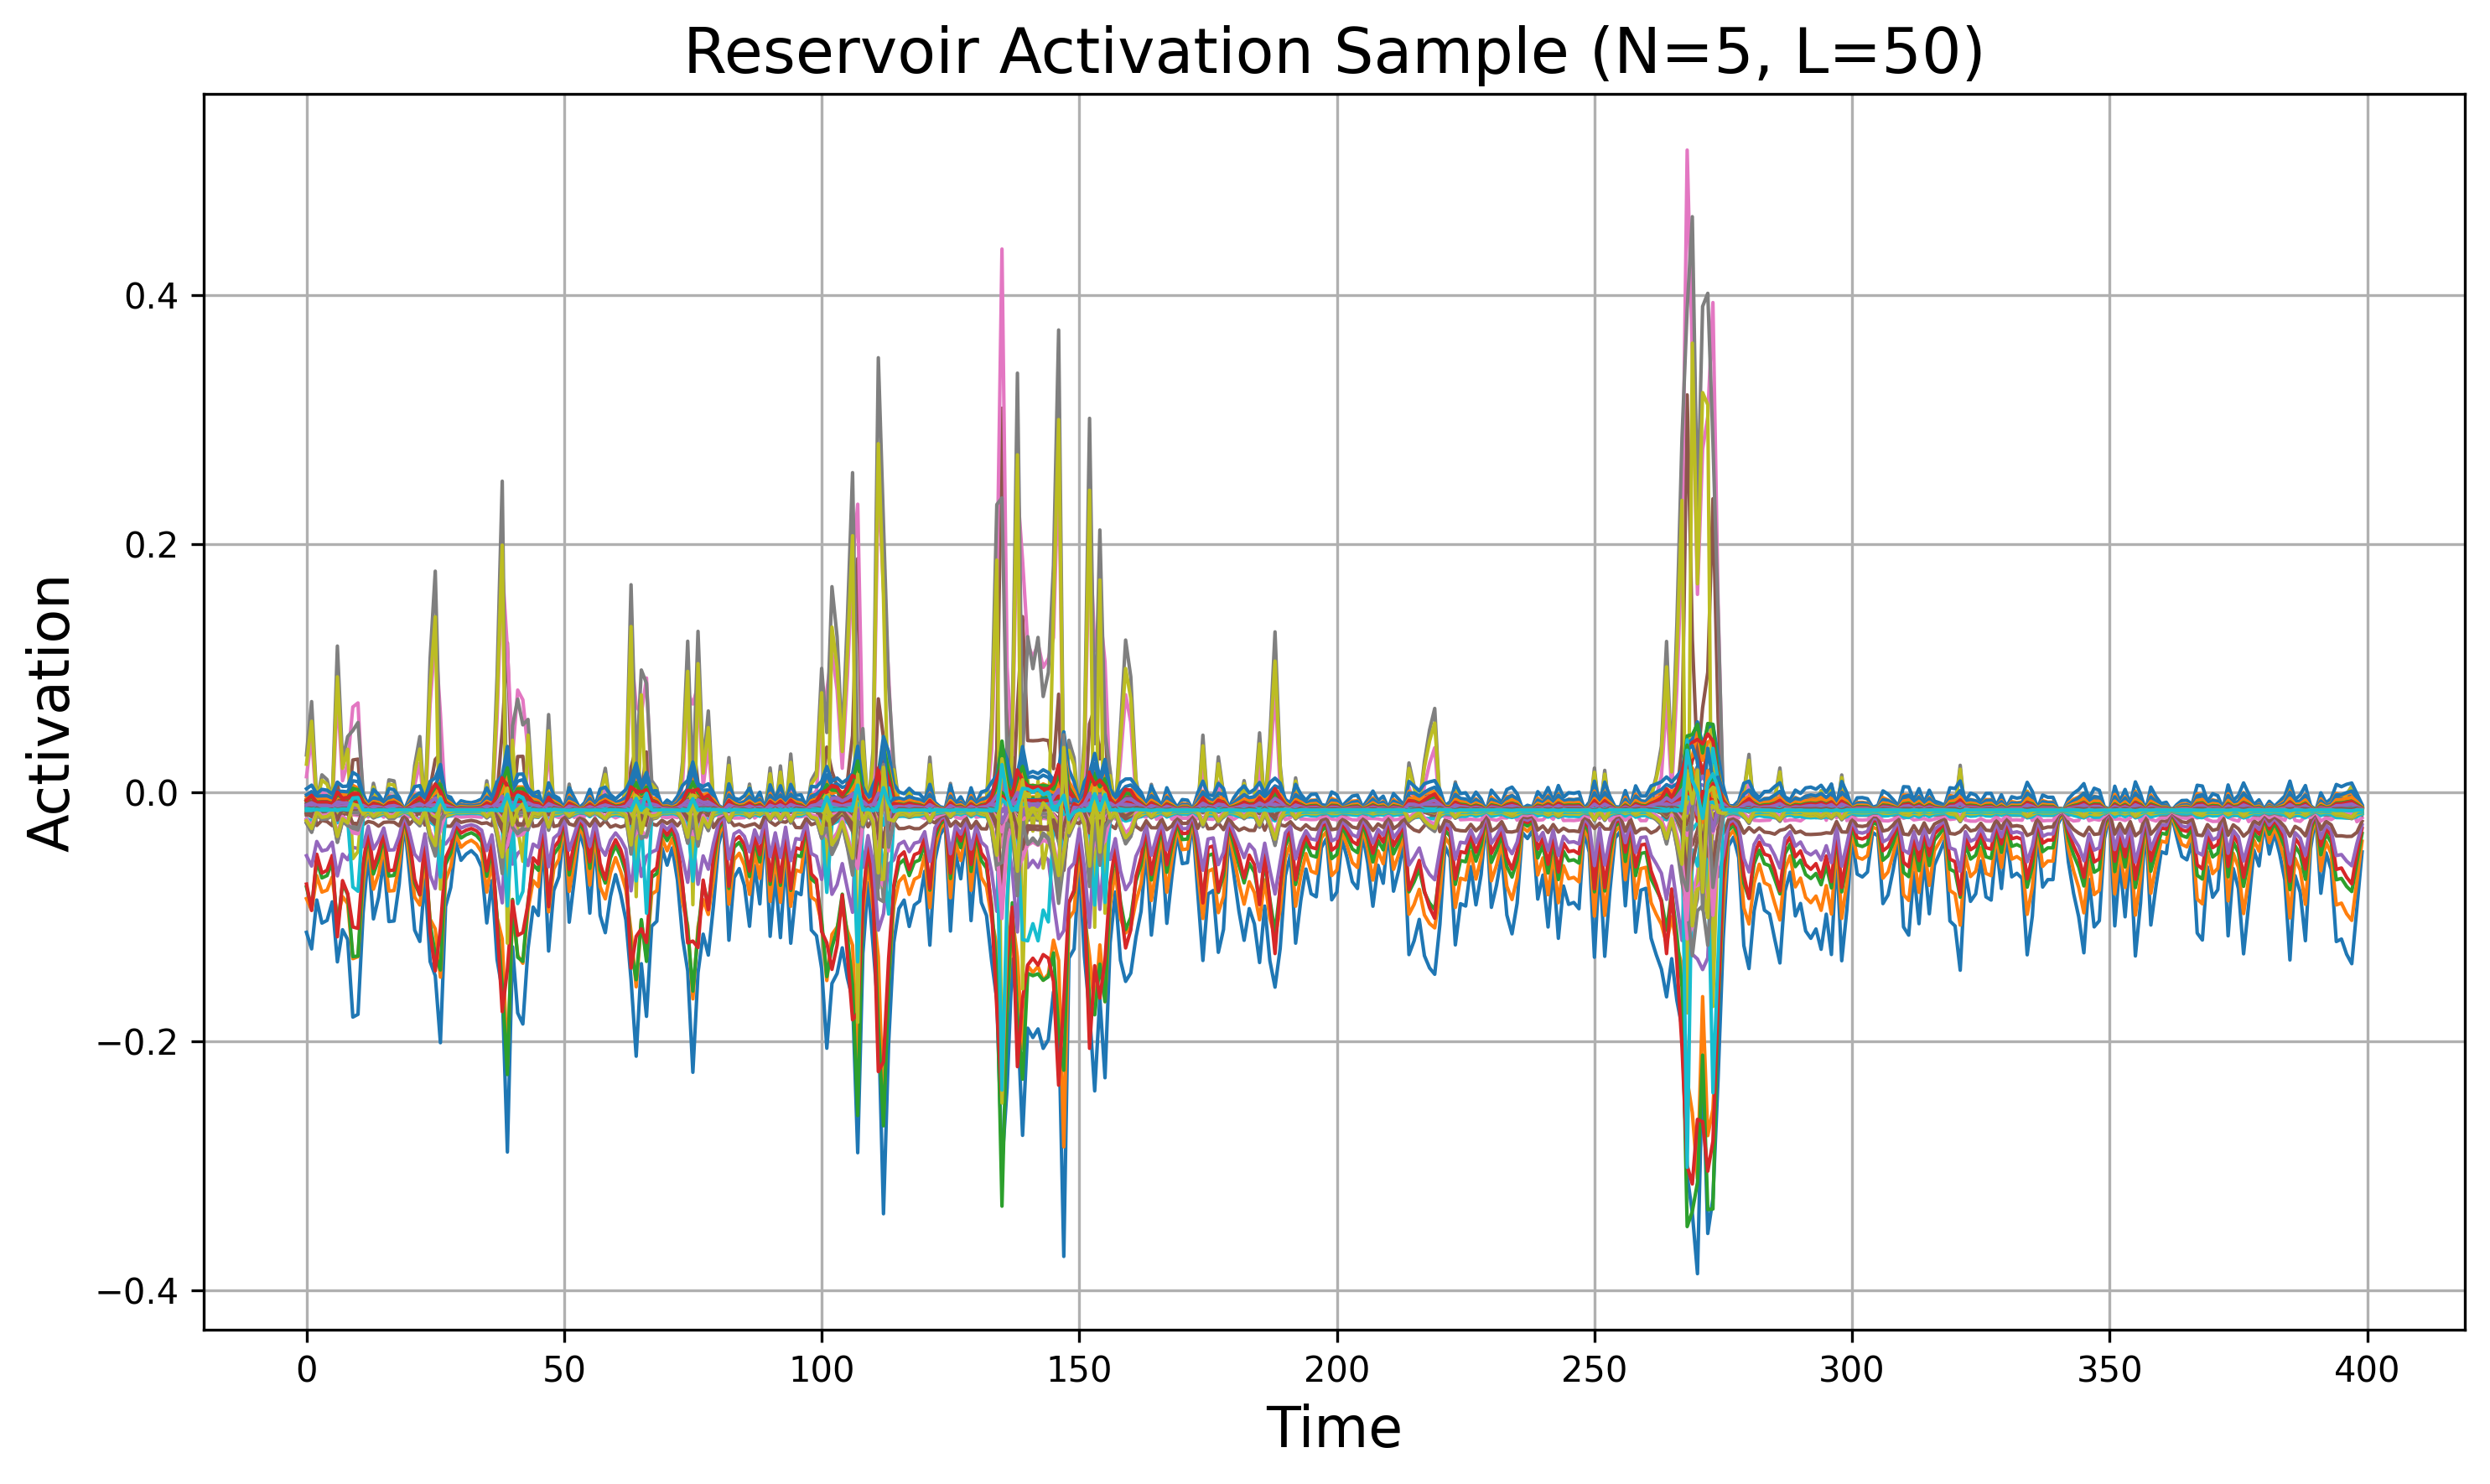

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'states' is already defined and has the dimensions you mentioned
# If not, you should load or define 'states' here

# Select the range of data to plot (500th to 2000th entries, all 50 reservoirs, 0th dimension)
data_to_plot = np.array(states)[500:900, :, 0]

# Plot the results with high quality for publication
plt.figure(figsize=(10, 6), dpi=300)  # Figure size and dpi for high-resolution
for i in range(data_to_plot.shape[1]):
    plt.plot(data_to_plot[:, i], linewidth=1)  # Plot each reservoir with a thinner line

# Set labels with a larger font size for better readability
plt.xlabel('Time', fontsize=16)
plt.ylabel('Activation', fontsize=16)

# Add a title and optionally a grid
plt.title('Reservoir Activation Sample (N=5, L=50)', fontsize=18)
plt.grid(True)

# Use tight_layout to automatically adjust subplot params for a nice fit
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('reservoir_activation_sample.png', format='png', dpi=300)

# Display the plot
plt.show()

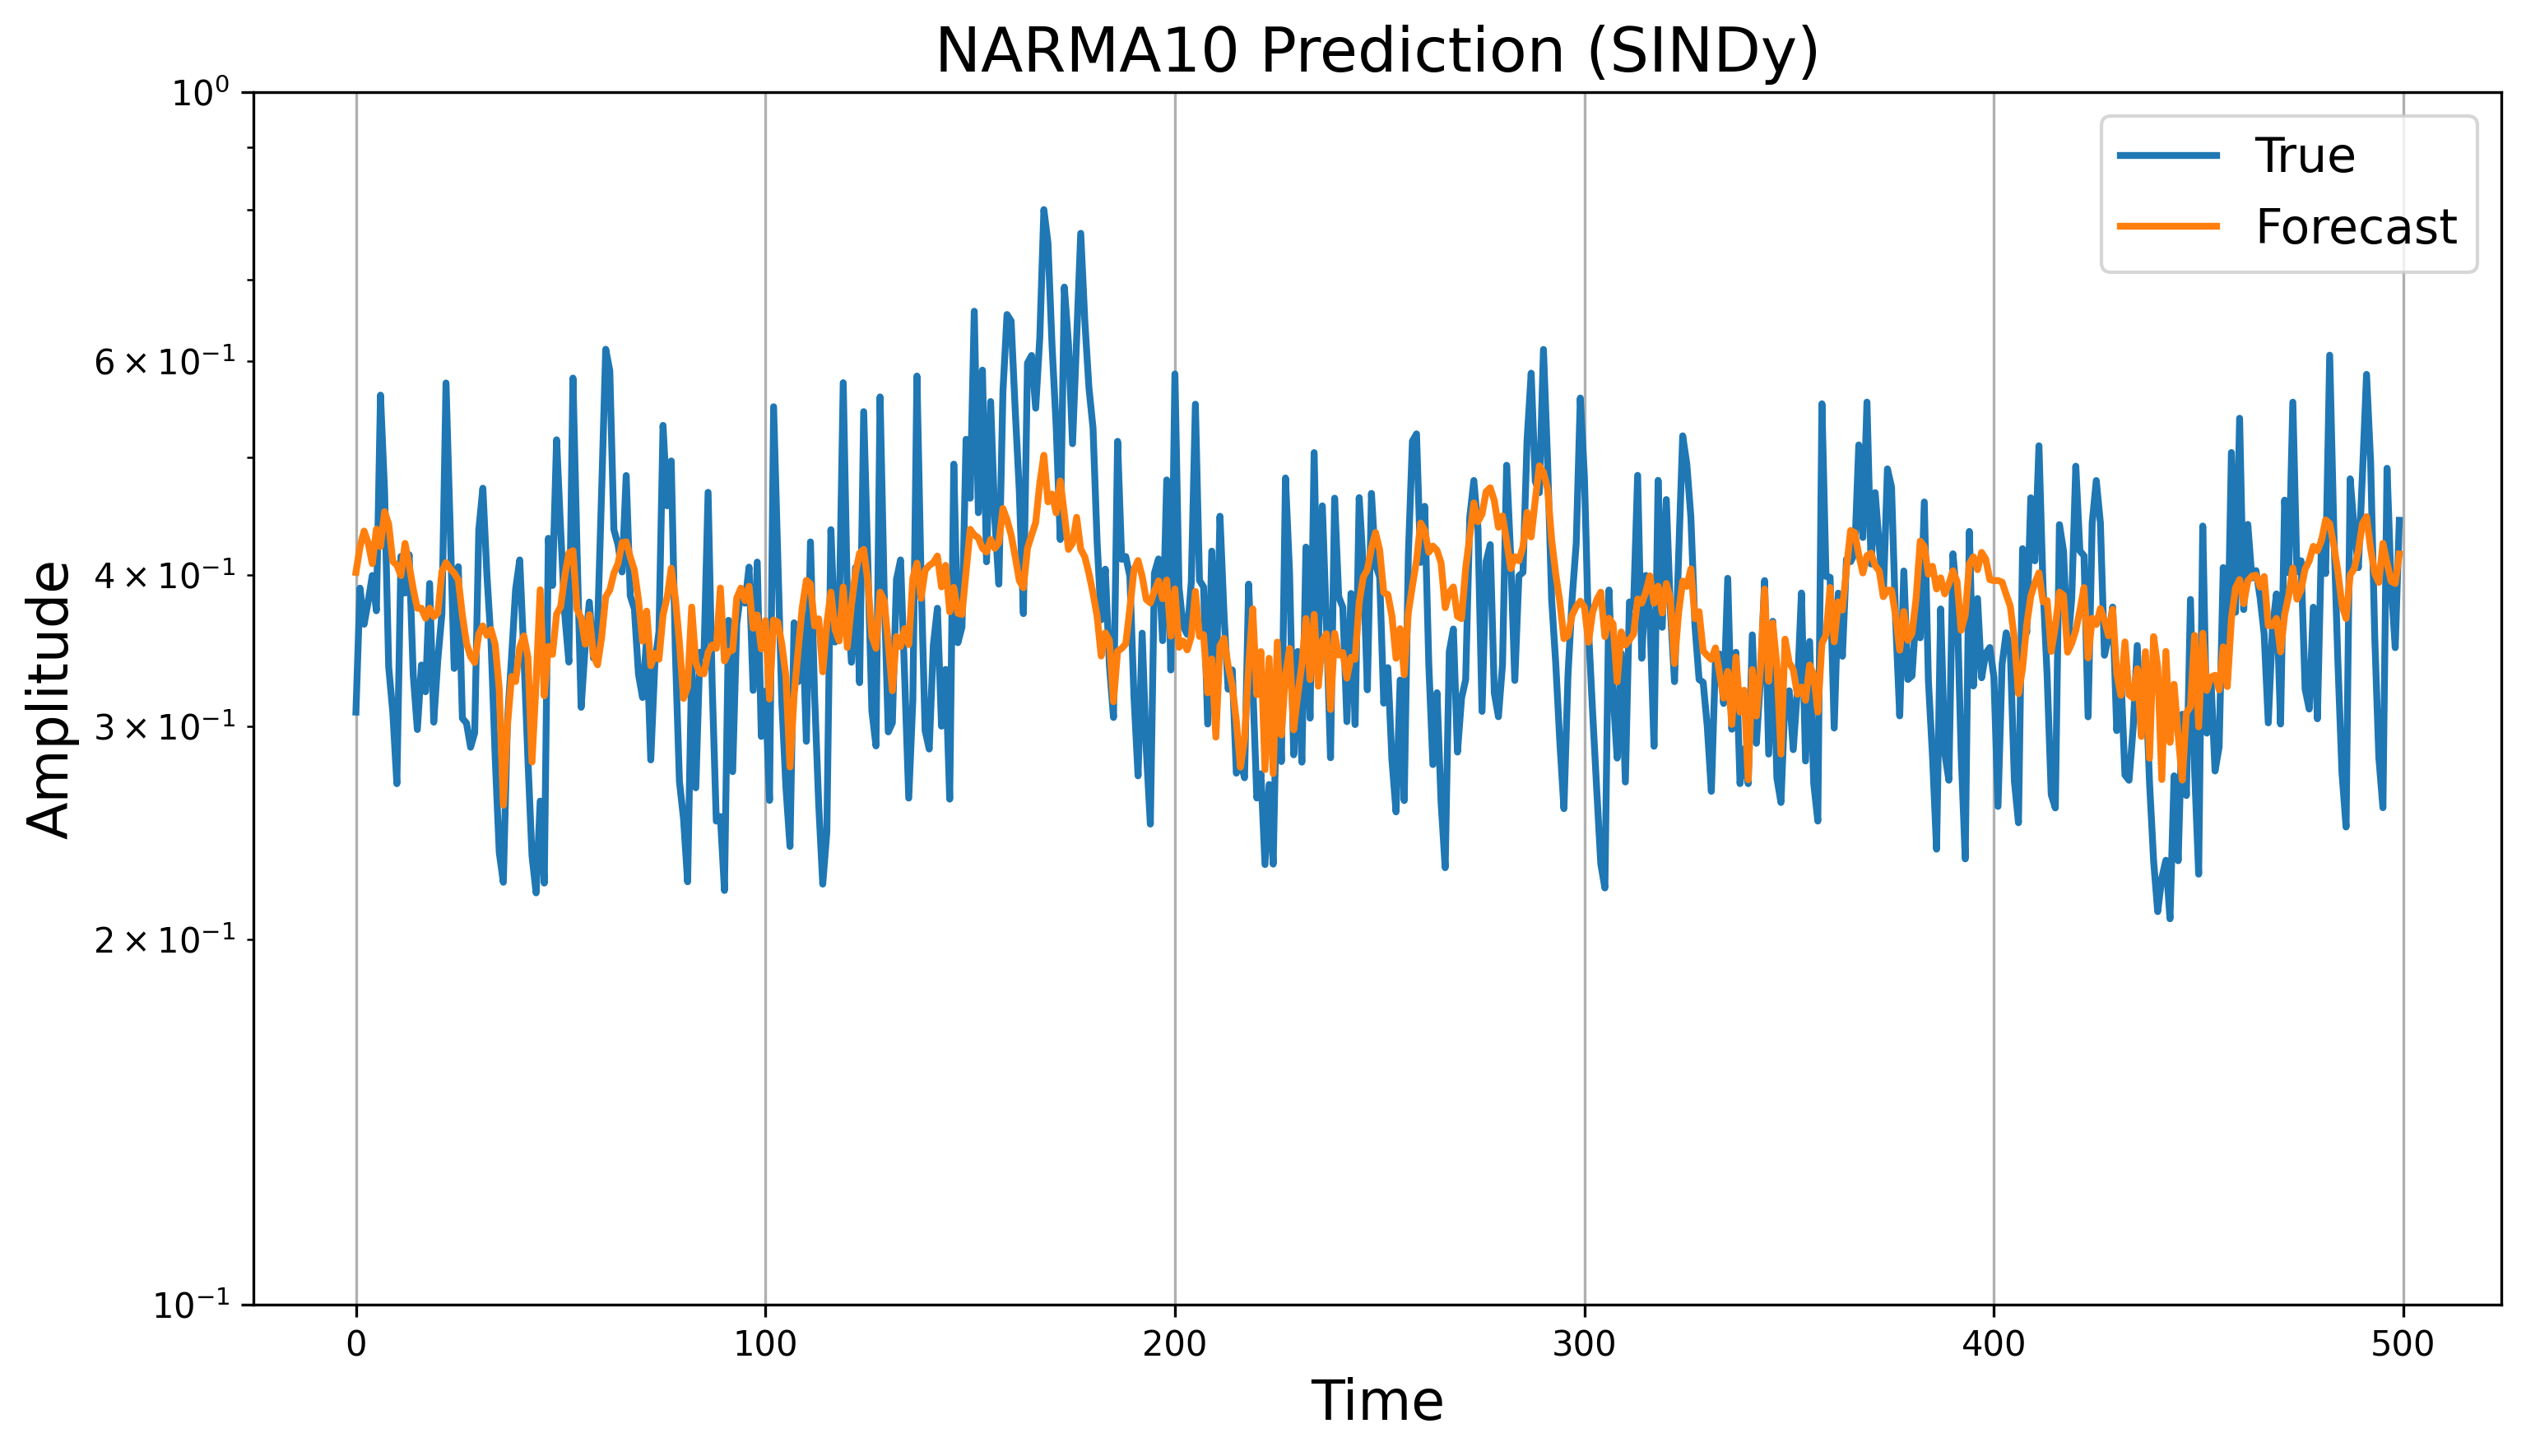

In [189]:
plt.figure(figsize=(10, 6), dpi=300)  # Larger figure size and high dpi for quality
plt.plot(y[500:], label='True', linewidth=2)  # Thicker line for better visibility
plt.plot(forecast[500:], label='Forecast', linewidth=2)
plt.legend(fontsize=14)  # Larger font size for legibility in a poster
plt.xlabel('Time', fontsize=16)  # Label for the x-axis with larger font
plt.ylabel('Amplitude', fontsize=16)  # Label for the y-axis with larger font
plt.title('NARMA10 Prediction (SINDy)', fontsize=18)  # Title with larger font
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit all elements neatly
plt.yscale("log")
plt.ylim([1e-1, 1e+0])
# Save the figure with high resolution
plt.savefig('narma10_prediction_sindy.png', format='png', dpi=300)

In [ ]:
Y_pred = np.zeros(200)
x = mackey_glass[200]

for i in range(100):
    x = esn.run(x)
    Y_pred[i] = x

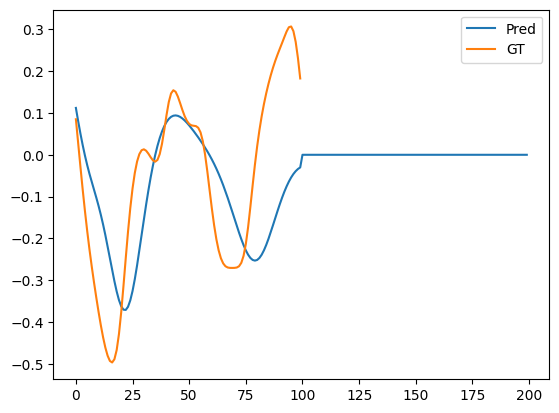

In [113]:
plt.plot(Y_pred, label='Pred')
plt.plot(mackey_glass[201:301], label='GT')
plt.legend()

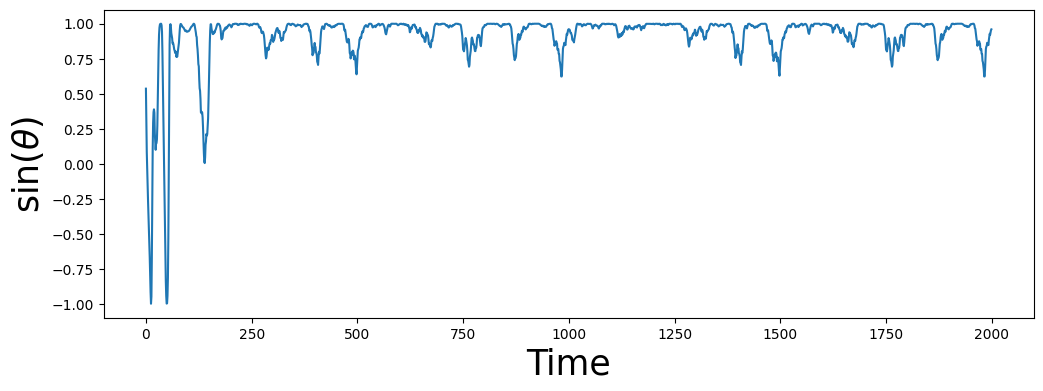

In [190]:
plot_activity(np.array(phases).T[4])

In [10]:
def derivative(angles_vec, t, adj_mat, coupling):
    '''
    Compute derivative of all nodes for current state, defined as

    dx_i    natfreq_i + k  sum_j ( Aij* sin (angle_j - angle_i) )
    ---- =             ---
     dt                M_i

    t: for compatibility with scipy.odeint
    '''
    assert len(angles_vec) == len(omega) == len(adj_mat), \
        'Input dimensions do not match, check lengths'

    angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    interactions = adj_mat * np.sin(angles_j - angles_i)  # Aij * sin(j-i)

    dxdt = omega + coupling * abs(omega) * interactions.sum(axis=0)
    #dxdt = self.natfreqs + coupling * interactions.sum(axis=0)  # sum over incoming interactions

    return dxdt

In [23]:
def mean_frequency(act_mat, adj_mat,K, c=1e-2, mean_length=100):
    '''
    Compute average frequency within the time window (self.T) for all nodes
    '''
    assert len(adj_mat) == act_mat.shape[0], 'adj_mat does not match act_mat'
    _, n_steps = act_mat.shape


    n_interactions = (adj_mat != 0).sum(axis=0)  # number of incoming interactions
    coupling = K / n_interactions

    # Compute derivative for all nodes for all time steps
    dxdt = np.zeros_like(act_mat)
    for time in range(n_steps):
        dxdt[:, time] = derivative(act_mat[:, time], None, adj_mat, coupling)

    # Integrate all nodes over the time window T
    integral = np.sum(dxdt * 0.1, axis=1)
    # Average across complete time window - mean angular velocity (freq.)
    meanfreq = integral / 1

    var_arr = []

    for i in range(1, mean_length):
        var_arr.append(np.exp(-c*np.var(dxdt[:,-i])))
    variance_order = np.mean(var_arr)

    variance_order = np.mean(np.exp(-c*np.var(dxdt[:,-mean_length:])))
    return variance_order

In [24]:
def get_actmat_SINDy(K):
    omega = np.loadtxt('natfreqs_default.txt')[60:72]
    phase = np.zeros(12)
    adj_mat = np.loadtxt('adj_mat_default.txt')[60:72,60:72]

    sol = sim_explosive_kuramoto_data(omega.shape[0], 
                                      t_span=[0,20], 
                                      t_eval=np.linspace(0, 20, 2001), 
                                      K=K, omega=omega, 
                                      y0=np.random.randn(12), 
                                      adj_mat=adj_mat)
    
    # Include sin(x-y) term in library
    library_functions = [lambda x, y: np.sin(x - y)]
    library_function_names = [lambda x, y: "sin(" + x + "-" + y + ")"]
    custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
    poly_library = ps.PolynomialLibrary(degree=0)  # For constants (w_i)
    combined_library = custom_library + poly_library  # Concatenate library

    optimizer = ps.STLSQ(threshold=0.03)  # Threshold varies by random w (TODO: adaptive threshold?)

    # Instantiate and fit the SINDy model
    model = ps.SINDy(optimizer=optimizer, feature_library=combined_library)
    model.fit(sol.y.T[:1000], t=t_eval[:1000], unbias=False)  # unbias=False has better performance

    # Simulate the data using the discovered equations
    sim = model.simulate(sol.y[:, 0], t=t_eval)
    return sim

In [27]:

arr = []
np.random.seed(41)
k_list = np.linspace(1,4,11)
for k in k_list:
    act_mat_real = sim_explosive_kuramoto_data(12, t_span=[0,50], t_eval=np.linspace(0, 50, 501), K=k, omega=omega, y0=np.random.randn(12), adj_mat=adj_mat).y
    act_mat_sindy = get_actmat_SINDy(k).T
    arr.append([act_mat_real, act_mat_sindy])

In [36]:
var_sindy_arr = []
var_real_arr = []

for i,k in enumerate(k_list):
    act_mat_real, act_mat_sindy = arr[i]
    
    var_real = mean_frequency(act_mat_real, adj_mat, k, c=1e+1)
    var_sindy = mean_frequency(act_mat_sindy, adj_mat, k, c=1e+1)
    var_sindy_arr.append(var_sindy)
    var_real_arr.append(var_real)

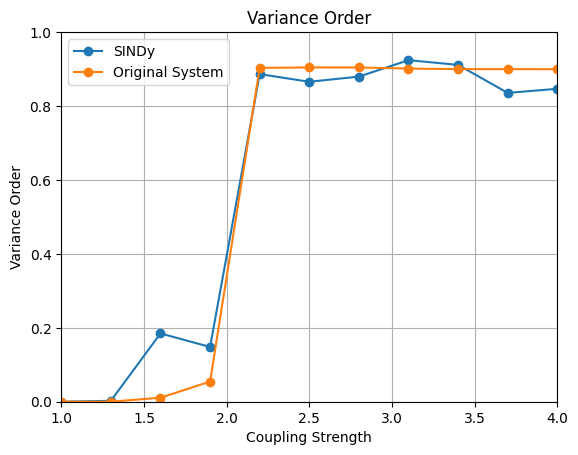

<Figure size 640x480 with 0 Axes>

In [191]:
plt.plot(k_list, var_sindy_arr, 'o-', label='SINDy')
plt.plot(k_list, var_real_arr, 'o-', label='Original System')
plt.xlabel('Coupling Strength')
plt.ylabel('Variance Order')
plt.title('Variance Order')
plt.legend()
plt.xlim([1,4])
plt.ylim([0,1])
plt.grid()
plt.show()
plt.savefig('Variance Order.png')

In [192]:
act_mat_real, act_mat_sindy = arr[5]

Text(0.5, 1.0, 'Reservoir Activity (RCK)')

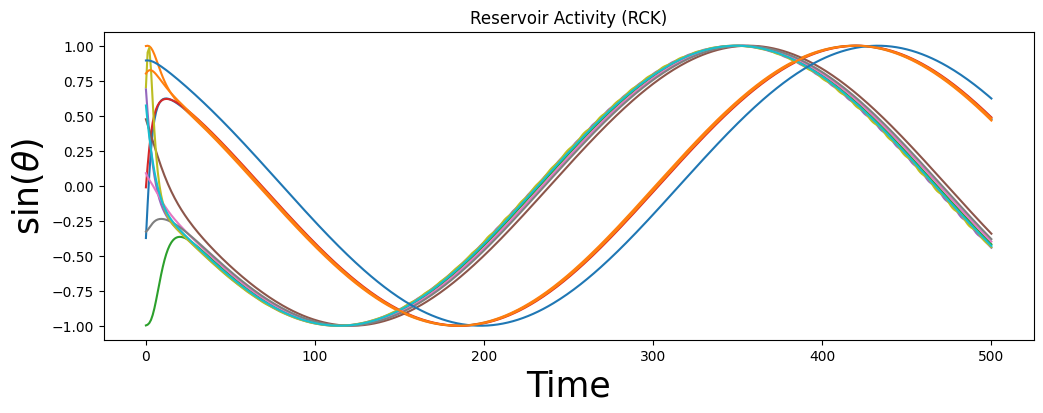

In [196]:
plot_activity(act_mat_real)
plt.title('Reservoir Activity (RCK)')

In [ ]:
np.array(phases).T.shape

In [ ]:
adj_mat.shape